# Clustering and visualizing the `penguins` dataset in 2D with *Self-Organizing Map*

In [01_kmeans_clustering.ipynb](./01_kmeans_clustering.ipynb) we use/used the `K-Means` algorithm to find groups of data points. In [02_som_representation_learning.ipynb](./02_som_representation_learning.ipynb) we use *Self-Organizing Map* to learn the representation of the dataset.

Here we want to find the optimal SOM hyperparameter combination that fits the data closely while the map still remaining organized.

In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

RAND = 42

## Dataset

In [16]:
X_scaled = pd.read_csv("../datasets/penguins/simple/X_scaled.csv", index_col=0, header=0)
X_scaled_idx = X_scaled.index
X_scaled = X_scaled.to_numpy()
y = pd.read_csv("../datasets/penguins/simple/y.csv", index_col=0, header=0)

## Representation learning

In [17]:
from _utilities.som import train_som

SOM_DIM = 12
SOM_SIGMA = SOM_DIM / 3
SOM_NUM_ITERATION = 100
SOM_LEARNING_RATE = .5

hyparams = {
    "d1": SOM_DIM,
    "d2": SOM_DIM,
    "sigma": SOM_SIGMA,
    "learning_rate": SOM_LEARNING_RATE,
    "num_iteration": SOM_NUM_ITERATION,
    "topology": "rectangular"
}

som = train_som(X=X_scaled, **hyparams, random_seed=RAND, verb=True)

node_weights = som.get_weights()
node_weights_flat = node_weights.reshape(-1, node_weights.shape[2])
activation_map = som.activation_response(X_scaled)
activations_flat = activation_map.flatten()

assert som.topographic_error(X_scaled) < .1, "The SOM is not organized!"

 [ 34200 / 34200 ] 100% - 0:00:00 left 
 quantization error: 0.4533975116168289

Brief quality of SOM:
Quantization error:	0.453
Topographic error:	0.012
Topographic error (VN):	0.082


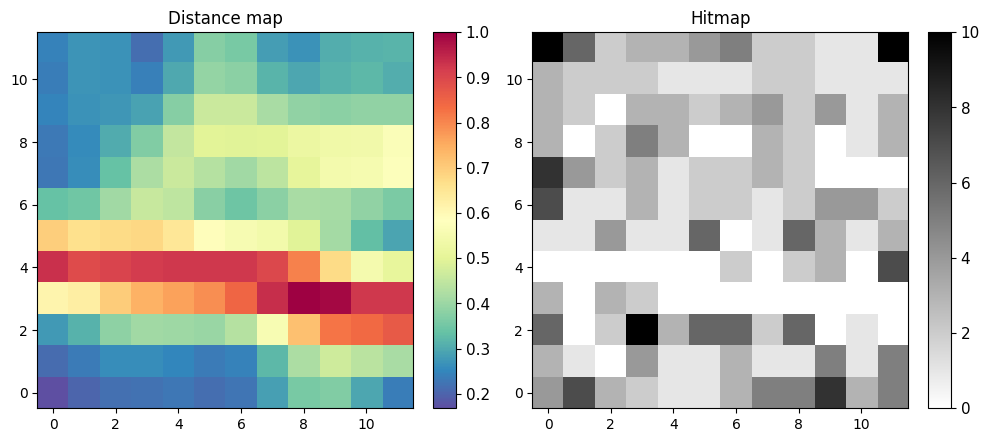

In [18]:
from _utilities.som_plot import visualize_distance_map, visualize_hitmap

fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(10, 5))

visualize_distance_map(som=som, X=X_scaled, ax=ax0)
visualize_hitmap(som=som, X=X_scaled, ax=ax1)

plt.tight_layout()
plt.show()

## Clustering

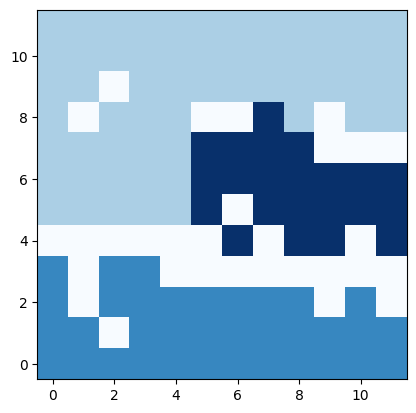

In [19]:
from sklearn.cluster import AgglomerativeClustering

clustering = AgglomerativeClustering(n_clusters=3, linkage="ward")
clustering.fit(node_weights_flat)

clustering_map = clustering.labels_.reshape(activation_map.shape)
clustering_map[activation_map == 0] = -1

plt.imshow(clustering_map, origin="lower", cmap="Blues")
plt.show()

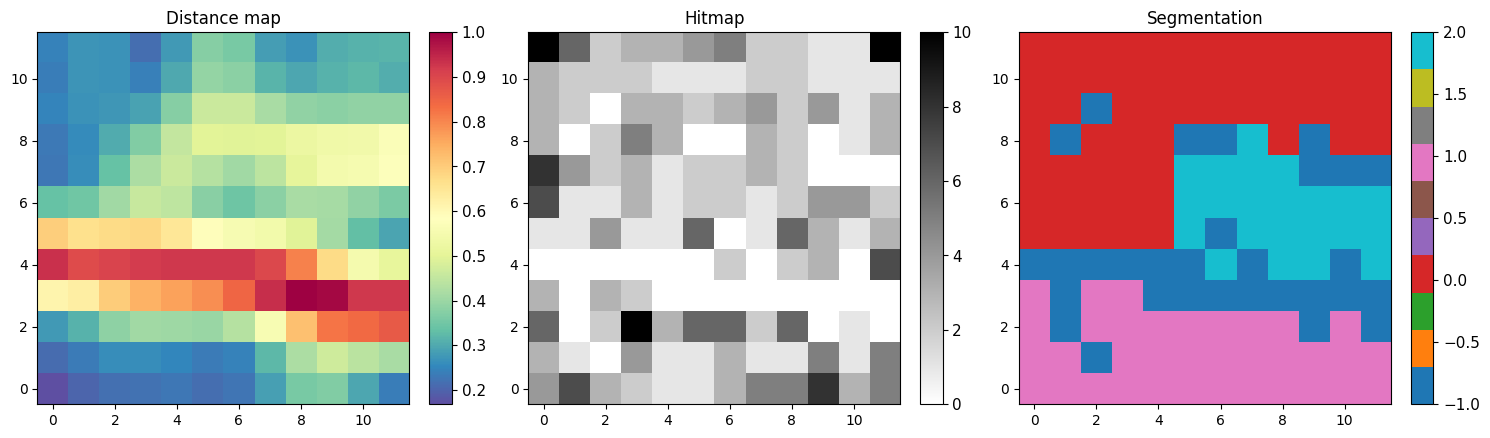

In [20]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

fig, (ax0, ax1, ax2) = plt.subplots(1, 3, figsize=(15, 5))

visualize_distance_map(som=som, X=X_scaled, ax=ax0)
visualize_hitmap(som=som, X=X_scaled, ax=ax1)

ax2.set_title("Segmentation")
seg = ax2.imshow(clustering_map, origin="lower", cmap="tab10")
divider = make_axes_locatable(ax2)
cax = divider.append_axes("right", size="6%", pad=0.2)
cax.tick_params(labelsize=11)
cbar = plt.colorbar(seg, cax=cax)

plt.tight_layout()
plt.show()

In [21]:
# make clustering predictions and export

y_pred = np.array([clustering_map[som.winner(x)] for x in X_scaled])

df_pred = pd.DataFrame(y_pred, index=X_scaled_idx, columns=['cluster_id'])
df_pred.to_csv("predictions/03_01_som_clustering_predictions.csv")